In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns

In [2]:
def features_value_couts(df):
    writer = pd.ExcelWriter('agrupamento.xlsx', engine='xlsxwriter')

    for col in list(df.columns):
        df2 = df[col].value_counts()
        df2.to_excel(writer, sheet_name = col)

    writer.save()

### Filtering land transport companies by subgroup numbers

In [3]:
whole_data = pd.read_csv(r'preprocessing_codes/null_treated_dataset.csv', sep=";")
whole_data.shape

C:\Users\liand\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,22,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2767166, 27)

In [4]:
df_transporte = whole_data.loc[whole_data.cd_cnae.isin([4940,4911,4912,4930,4924,4922,4921,4929,4923,4950])].copy()
df_transporte.shape

(102384, 27)

In [5]:
df_transporte.dt_acidente = pd.to_datetime(df_transporte.dt_acidente)
df_transporte.dt_nascimento = pd.to_datetime(df_transporte.dt_nascimento)

In [6]:
qtd_nulos = pd.DataFrame()
qtd_nulos['qtd'] = df_transporte.isna().sum().sort_values().copy()
qtd_nulos['percentual'] = qtd_nulos['qtd'] / len(df_transporte) * 100
qtd_nulos.sort_values(by='qtd', ascending = False).style.format({'qtd' : '{:,}','percentual' : '{:.2f}%'})

,qtd,percentual
dt_despacho_beneficio,"101,728",99.36%
tp_empregador,"101,249",98.89%
cnpj_empregador,"83,198",81.26%
dt_afastamento,"64,118",62.63%
uf_acidente,"31,325",30.60%
dt_emissao,"10,947",10.69%
cbo_descricao,"5,445",5.32%
cid_descricao,"4,307",4.21%
cd_cid,"4,307",4.21%
agente_causador,927,0.91%


In [7]:
df = df_transporte.drop(columns=['dt_despacho_beneficio','tp_empregador','cnpj_empregador','dt_afastamento','uf_acidente','dt_emissao',
                                           'origem_Cadastramento'], axis=1).copy()
df.dropna(inplace=True)
print(df.shape)

(91614, 20)


In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91614 entries, 3 to 2767160
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   agente_causador          91614 non-null  object        
 1   cd_cbo                   91614 non-null  int64         
 2   cbo_descricao            91614 non-null  object        
 3   cd_cid                   91614 non-null  object        
 4   cid_descricao            91614 non-null  object        
 5   cd_cnae                  91614 non-null  int64         
 6   cnae_descricao           91614 non-null  object        
 7   emitente                 91614 non-null  object        
 8   especie_beneficio        91614 non-null  object        
 9   filiacao_segurado        91614 non-null  object        
 10  indica_obito             91614 non-null  object        
 11  municipio_empregador     91614 non-null  object        
 12  natureza_lesao           91614

### Number of categories by attributes

In [9]:
nunique_nucategorias =  pd.DataFrame(df.nunique().sort_values(ascending=False).copy())
nunique_nucategorias = nunique_nucategorias.reset_index()
nunique_nucategorias.columns = ['Atributos', 'nu_categorias']
nunique_nucategorias.style.format({'nu_categorias' : '{:,}'})

,Atributos,nu_categorias
0,dt_nascimento,"17,521"
1,cd_cid,"2,599"
2,cid_descricao,"2,599"
3,cd_municipio_empregador,"2,112"
4,municipio_empregador,"2,112"
5,dt_acidente,"2,054"
6,cd_cbo,808
7,cbo_descricao,808
8,agente_causador,281
9,parte_corpo_atingida,39


### Inclusion of columns

In [10]:
print("Number of inconsistent: ", df.loc[df.dt_acidente < df.dt_nascimento].shape)

df['idade'] = (df.dt_acidente - df.dt_nascimento) // timedelta(days=365.2425)
df['idade'] = df['idade'].astype('int64')
print("Number of rows with less than 14 years old: ",  df.idade.loc[df.idade <14].count())

Number of inconsistent:  (0, 20)
Number of rows with less than 14 years old:  0


<AxesSubplot:xlabel='idade'>

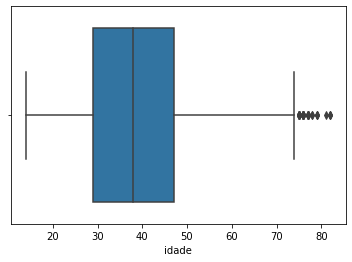

In [11]:
sns.boxplot(x=df.idade)

In [12]:
Q1 =  df.idade.quantile(.25)
Q3 =  df.idade.quantile(.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print("Limite inferior: ", limite_inferior)
print("Limite superior: ", limite_superior)
print("Max. age: ", max(df.idade))
print("Min. age: ", min(df.idade))
print("Number of outliers: ", df.idade.loc[(df.idade < limite_inferior) | (df.idade > limite_superior)].count())

Limite inferior:  2.0
Limite superior:  74.0
Max. age:  82
Min. age:  14
Number of outliers:  41


In [13]:
df.loc[:, 'idade'] = pd.qcut(df.idade,5)

In [14]:
df_cid = pd.read_csv(r'atributtes/cid.csv', sep=";")
df_cid = df_cid[['cd_subgrupo', 'cid_grupo','cid_capitulo']].drop_duplicates()

df['cd_subgrupo'] = df.cd_cid.apply(lambda x: str(x)[:3])
df = df.merge(df_cid, on='cd_subgrupo', how='left').copy()

In [15]:
df_cbo = pd.read_csv(r'atributtes/cbo.csv', sep=";")
df_cbo = df_cbo[['cd_cbo', 'cbo_subgrupo_principal']].drop_duplicates()

df = df.merge(df_cbo, on='cd_cbo', how='left').copy()

In [16]:
df['dt_mes_acidente'] = pd.DatetimeIndex(df.dt_acidente).month

In [19]:
nunique_nucategorias =  pd.DataFrame(df.nunique().sort_values(ascending=False).copy())
nunique_nucategorias = nunique_nucategorias.reset_index()
nunique_nucategorias.columns = ['Atributos', 'nu_categorias']
nunique_nucategorias.style.format({'nu_categorias' : '{:,}'})

,Atributos,nu_categorias
0,dt_nascimento,"17,521"
1,cd_cid,"2,599"
2,cid_descricao,"2,599"
3,cd_municipio_empregador,"2,112"
4,municipio_empregador,"2,112"
5,dt_acidente,"2,054"
6,cd_cbo,808
7,cbo_descricao,808
8,cd_subgrupo,794
9,agente_causador,281


In [22]:
df_final = df.drop(columns=['dt_nascimento', 'cd_cid', 'cid_descricao', 'cd_cnae', 'cd_subgrupo'])

In [24]:
nunique_nucategorias =  pd.DataFrame(df_final.nunique().sort_values(ascending=False).copy())
nunique_nucategorias = nunique_nucategorias.reset_index()
nunique_nucategorias.columns = ['Atributos', 'nu_categorias']
nunique_nucategorias.style.format({'nu_categorias' : '{:,}'})

,Atributos,nu_categorias
0,municipio_empregador,"2,112"
1,cd_municipio_empregador,"2,112"
2,dt_acidente,"2,054"
3,cbo_descricao,808
4,cd_cbo,808
5,agente_causador,281
6,cid_grupo,154
7,cbo_subgrupo_principal,41
8,parte_corpo_atingida,39
9,natureza_lesao,29


In [25]:
df_final.to_csv('land_transport_dataset.csv', sep=";")